In [ ]:
import os
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sympy import *
import mtcnn
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

### Part 1: Dataset Selection and Preprocessing (15 points)

#### Testing pre-processing and face detection on one file

In [ ]:
filename = 'yalefaces/subject01.centerlight'
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis = 2)
print(rgb_pixels.shape)

plt.imshow(pixels)
plt.show()

Create the detector to detect only the face in the image

In [ ]:
# Create the detector
detector = MTCNN()

# Detect the faces in the image
results = detector.detect_faces(rgb_pixels)

Define a function to draw an box around the detected face

In [ ]:
def draw_image_with_boxes(data, face_detection_results):
    plt.imshow(data)
    
    # Get the current axes on the plot
    ax = plt.gca()
    
    for result in face_detection_results:
        # Get the coordinates
        x, y, width, height = result['box']
        
        # Create the shape
        rect = Rectangle((x,y), width, height, fill=False, color='red')
        
        # Draw the rectangle
        ax.add_patch(rect)
        
    plt.show()
    
# Display faces image 'subject01.centerlight'
draw_image_with_boxes(rgb_pixels, results)

Define a function to extract a face from a file

In [61]:
def extract_face_from_file(filename, required_size=(224, 224)):
    # Load image from file
    image = Image.open(filename)
    
    return extract_face(image, required_size)

Define a function to extract a face from an image

In [72]:
def extract_face(image, required_size=(224, 224)):
    # Convert the image to RGB
    
    image = image.convert('RGB')
    
    # Convert the image to an array
    pixels = np.asarray(image)
    
    # Detect the faces in the image
    results = detector.detect_faces(pixels)
    
    # Get the coordinates of the face
    x1, y1, width, height = results[0]['box']
    
    # Bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # Extract the face
    face = pixels[y1:y2, x1:x2]
    
    # Resize the pixels / image
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image).copy()
    
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
     # Resize image to model size
    face_array[:,:,0] = gray_face
    face_array[:,:,1] = gray_face
    face_array[:,:,2] = gray_face
    
    
    return gray_face

1/1 [==============================] - 0s 31ms/step


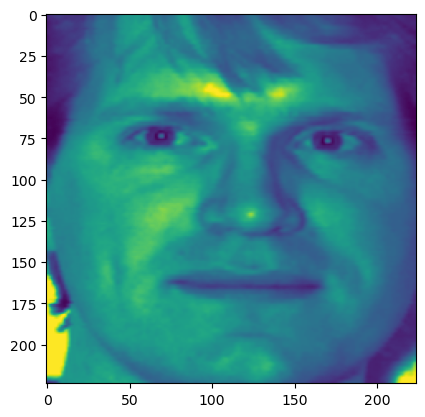

In [73]:
# Load the photo and extract the face
face_pixels = extract_face_from_file("yalefaces/subject01.centerlight")

# Show extracted face
plt.imshow(face_pixels)

#### Applying the logic for all files in the Yale Face database

Define a function to get load and preprocess the data

In [ ]:
def load_images(image_directory):
    face_images = []
    i = 1
    for file in os.listdir(image_directory):
        # Load the image from the directory as a PIL image
        image_path = os.path.join(image_directory, file)
        
        # Extract the face using the function extract_face_from_file
        face = extract_face_from_file(image_path)
        
         # Set up subplot
        plt.subplots(4, 4)
        plt.axis('off')
        plt.imshow(face)

        # Add face to faces list
        face_images.append(face)
        i+=1
    
    plt.show()    
    return face_images

# Load images in the directory yalefaces
load_images('yalefaces')

1/1 [==============================] - 0s 27ms/step


C:\Users\Sama\AppData\Local\Temp\ipykernel_29144\3650299799.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(4, 4)


1/1 [==============================] - 0s 23ms/step


#### Part 2: Eigenface Generation (20 points)

Load the images from the 'yalefaces' directory and flatten them into a dataset

In [11]:
X = np.asarray(process_images('yalefaces'))

TypeError: 'numpy.ndarray' object is not callable

TypeError: Invalid shape (50176,) for image data

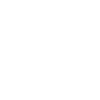

In [9]:
# Set up subplot
plt.subplot(4, 4, 1)
plt.axis('off')
plt.imshow(X[0])
plt.show()

Confirm the shape of the flattened dataset. Since the dataset contains 165 images and we have resized the images into 300 by 400 size, we should expect the shape to by 165 by 64 * 64

In [5]:
X.shape

(165, 2500)

Calculate the average face image

In [6]:
# Get the length of the images array
length_dataset = X.shape[0]

mean_face = np.sum(X, axis=0, dtype='float64') / length_dataset

Find the mean matrix using the numpy tile function. np.tile constructs an array by repeating a given dataset by the number of times specified

In [7]:
mean_matrix = np.tile(mean_face, (length_dataset, 1)) 

Mean-center the image data. Mean-centering calculates the difference between the mean value and the actual value, ensuring that we are only looking at the variance in the dataset

In [8]:
X_centered = X - mean_matrix

Caclulate the co-variance in the data. Convariance is a measure of the relationship between two variables.

In this case, we calculate the co-variance by finding the dot product of the image data and a transposed version of the image data

In [9]:
covariance_matrix = (X_centered.dot(X_centered.T)) / length_dataset

Find the eigenvalues and eigenvectors using the covariance matrix. Because they are square and symmetrical, covariance matrixes are diagonalizable, which means an eigendecomposition can be performed on the matrix.

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

In [11]:
eigenvalues

array([ 3.33326006e+06+0.00000000e+00j,  1.52599003e+06+0.00000000e+00j,
        9.56452718e+05+0.00000000e+00j,  8.07260102e+05+0.00000000e+00j,
        5.06382591e+05+0.00000000e+00j,  4.41204630e+05+0.00000000e+00j,
        2.90799269e+05+0.00000000e+00j,  2.39541432e+05+0.00000000e+00j,
        2.34898615e+05+0.00000000e+00j,  1.94322500e+05+0.00000000e+00j,
        1.37847598e+05+0.00000000e+00j,  1.16257401e+05+0.00000000e+00j,
        9.36427084e+04+0.00000000e+00j,  9.01826374e+04+0.00000000e+00j,
        8.77712605e+04+0.00000000e+00j,  8.04618289e+04+0.00000000e+00j,
        7.38324071e+04+0.00000000e+00j,  6.41477082e+04+0.00000000e+00j,
        6.22117346e+04+0.00000000e+00j,  5.97069618e+04+0.00000000e+00j,
        5.08778993e+04+0.00000000e+00j,  4.72798036e+04+0.00000000e+00j,
        4.26912174e+04+0.00000000e+00j,  4.03352813e+04+0.00000000e+00j,
        3.77239473e+04+0.00000000e+00j,  3.63773901e+04+0.00000000e+00j,
        3.16509969e+04+0.00000000e+00j,  2.91714546

Find the order of the eignevalues

In [12]:
order = eigenvalues.argsort()[::-1]

Sort the eigenvalues by their order

In [13]:
eigenvalues = eigenvalues[order]

Get the principal components

In [14]:
eigenvectors_C = eigenvectors[:, order]

Project all images to the eigen space

In [15]:
eigenvectors_C = X_centered.T @ eigenvectors 

Normalize all the eigenfaces

In [16]:
eigenfaces = preprocessing.normalize(eigenvectors_C.T)

ValueError: Complex data not supported
[[-6.58237087e+01+0.j -5.58298828e+01+0.j -5.43156059e+01+0.j ...
   3.51621356e+02+0.j  3.24839476e+02+0.j  3.04224719e+02+0.j]
 [ 1.14763727e+02+0.j  1.02401145e+02+0.j  9.83731149e+01+0.j ...
   3.60919810e+02+0.j  3.42864063e+02+0.j  3.36812258e+02+0.j]
 [-6.32229248e+01+0.j -6.36312392e+01+0.j -5.90238792e+01+0.j ...
  -5.18946391e+01+0.j -2.47224170e+01+0.j -1.38836523e+01+0.j]
 ...
 [ 4.32334374e-14+0.j  4.15876313e-14+0.j  3.77867484e-14+0.j ...
  -3.64170012e-14+0.j -9.33756207e-15+0.j  2.25933227e-14+0.j]
 [ 6.23550619e-14+0.j  9.04577065e-14+0.j  6.02001937e-14+0.j ...
  -2.13135699e-13+0.j -2.41041841e-13+0.j -2.38877967e-13+0.j]
 [ 6.21910876e-14+0.j  8.55395776e-14+0.j  6.36752607e-14+0.j ...
  -1.53167792e-13+0.j -1.84660219e-13+0.j -1.73713386e-13+0.j]]


Plot the first eigenface

In [ ]:
plt.imshow(np.resize(eigenfaces[0], (nrows,ncolumns)), cmap='gray')
plt.title('First Eigen Face')
plt.show()